# Project 2: Ames Housing Data and Kaggle Challenge

## Problem Statement
---

A real estate agent in Ames is working with first-time homebuyers who qualified for the city's Homebuyer Assistance Program (HOME).  The homebuyers created a list of house features that are important to them in order to narrow down the list of homes to visit. To make a more informed and realistic list of must-haves and good-to-haves, the family requested information on current trends in home sales. Based on historical home sales in Ames, what are some features that are more likely to increase the cost of a home?

## Background & Outside Research
---

The city of Ames Iowa offers a homebuyer assistance program called Home Investment Partnership Grant (HOME). The program provides approved individuals with incomes at or below 80% the area median income limits financial assistance to purchase homes in Ames. Financial assistance may be given to cover down payment costs, closing costs, and/or PITI principal, interest, tax, insurance) payments. The total amount of assistance cannot exceed $\$$13,500.

Knowing that applicants will have restrictions on home price due to income-level, it will be important for them to know what features are most likely to impact cost and potentially be out of range for them.

**Notable Conditions** ([*source*](https://www.cityofames.org/Home/ShowDocument?id=15833))

- most recently, for a family of 4, gross income cannot exceed \$71,950. ([*source*](https://www.cityofames.org/home/showpublisheddocument/65504/637816353835670000)).
- all homebuyers must contribute a minimum of \$1,500 or 1.5% of the purchase price of the home, whichever is greater
- Applicants must attend seminars and receive a certification of completion before being eligible for the grant
- Applicant selection is on a first-come, first-serve basis
- Property must be a single-family home, town-home, or modular home.

### Choose your Data
---

There are 2 datasets included in the [`datasets`](./datasets/) folder for this project that I will be using. I wil use the training data to create and refine model. Then I will use the test data to see how my model performs on unseen data.

* [`train.csv`](./datasets/train.csv): train dataset has all columns/features needed to create and refine models
* [`test.csv`](./datasets/test.csv): test dataset has all columns/features except for the target ('SalePrice')

--- 
# Part 1 - EDA & Data Cleaning

---

In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, RidgeCV
from sklearn import metrics
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import warnings
warnings.filterwarnings('ignore')


In [3]:
pd.set_option('display.max_rows', 200)

## Data Import, EDA, and Pre-Cleaning
---
Note: imputing of missing values can be found in 02_Pre-Processing_and_Feature_Engineering notebook

In [4]:
# read in the data
housing = pd.read_csv('datasets/train.csv')
housing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
housing.shape

(2051, 81)

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [7]:
housing['SalePrice'].describe()
# just confirming that there isn't anything weird with min SalePrice - negative val
# the max is far from the mean which could indicate outliers

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

### Exploratory Visualizations
---

- How does neighborhood impact housing sale price? What neighbors have a higher mean sale price?
- What is the distribution of building types & house styles in the dataset?
- How many of the homes were remodeled recently? What was the saleprice?
- How do these features correlate to saleprice independently? KitchenQual, Gr Liv Area, Garage Type, Garage Area, Fence Quality

In [8]:
# creating a copy of the dataframe to use for visualizations
housing_EDA = housing.copy()

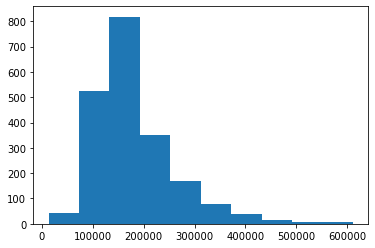

In [9]:
# plotting the distribution of sale price
plt.hist(housing_EDA['SalePrice']);

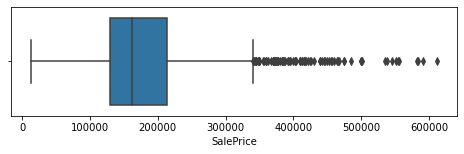

In [10]:
# plotting box plot of saleprice
plt.figure(figsize=(8,2))
sns.boxplot(data = housing_EDA,
            x = 'SalePrice',
            orient='h');

# I can see outliers here based on the boxplot

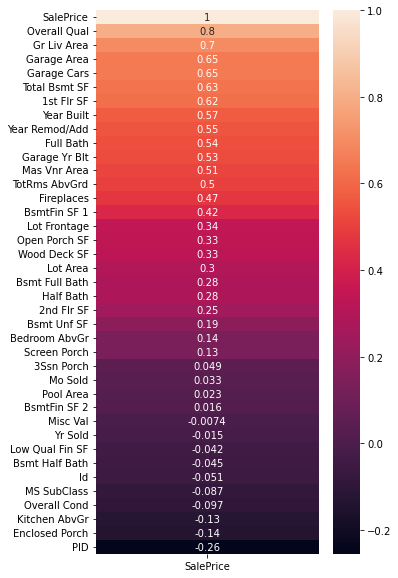

In [11]:
plt.figure(figsize = (5,10))
sns.heatmap(housing_EDA.corr()[['SalePrice']].sort_values(['SalePrice'], ascending=False), annot=True);

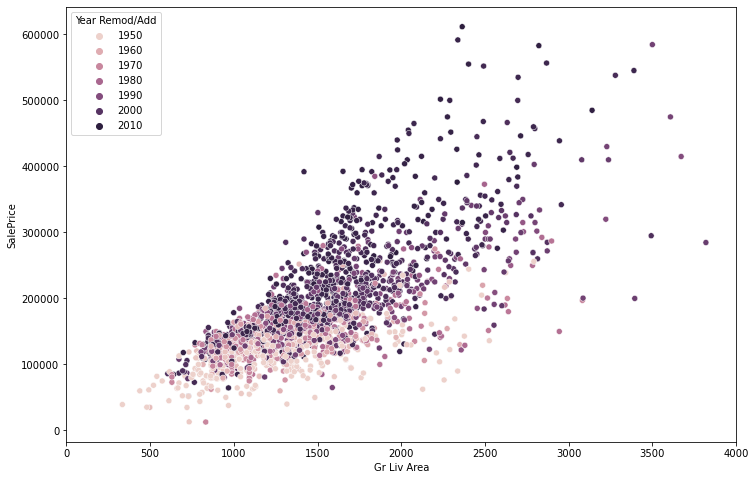

In [12]:
# plotting some scatter plots to salesprice
plt.figure(figsize = (12,8))
sns.scatterplot(data=housing_EDA, x='Gr Liv Area', y='SalePrice', hue='Year Remod/Add')
plt.xlim(0,4000);

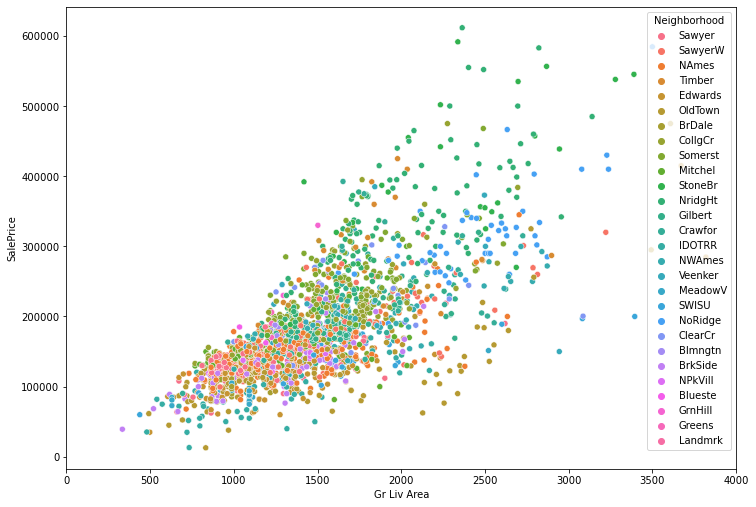

In [13]:
# scatter plots gr liv area to salesprice
# how does sale price trend if the house has a basement
plt.figure(figsize = (12,8.5))
sns.scatterplot(data=housing_EDA, x='Gr Liv Area', y='SalePrice', hue='Neighborhood')
plt.xlim(0,4000);

In [14]:
#mean saleprice and gr live area grouped by neighborhood
neighborhood = housing_EDA.groupby('Neighborhood')[['SalePrice']].mean().reset_index()
neighborhood.sort_values(by='SalePrice', ascending=False)

,Neighborhood,SalePrice
25,StoneBr,329675.736842
19,NridgHt,322831.352459
18,NoRidge,316294.125000
10,GrnHill,280000.000000
27,Veenker,253570.588235
26,Timber,241051.354167
24,Somerst,227183.900000
4,ClearCr,217490.074074
6,Crawfor,205901.211268
5,CollgCr,202497.216667


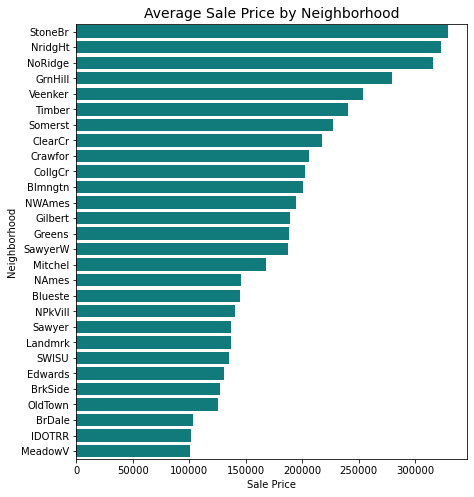

In [38]:
#average sale price of homes by neighborhood
plt.figure(figsize = (7,8))
sns.barplot(data=neighborhood.sort_values(by='SalePrice', ascending=False),
            orient='h',
            x='SalePrice',
            y='Neighborhood',
           color='darkcyan')
plt.xlabel('Sale Price')
plt.title('Average Sale Price by Neighborhood',
         fontsize=14,
         fontweight=10);

plt.savefig('/Users/debbiesim/Desktop/GADSI-Course/Projects/project-2/plots/plotsneighborhood.png')

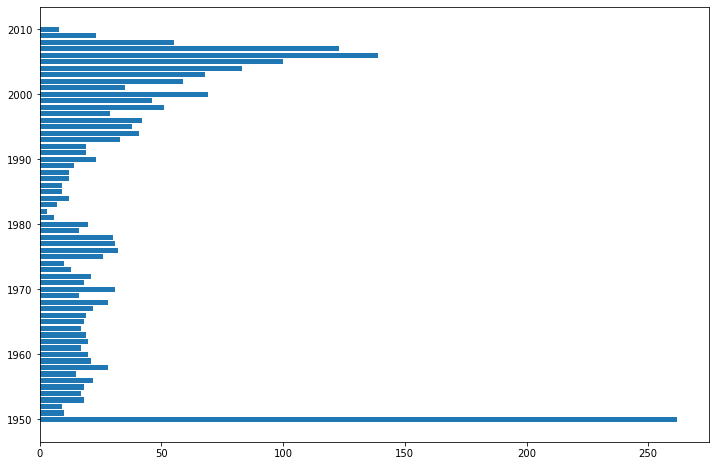

In [16]:
# creating a df of number of homes remodelled b year
remodel = pd.DataFrame(housing_EDA['Year Remod/Add'].value_counts()).reset_index()
remodel.sort_values(by='index', inplace=True)

plt.figure(figsize = (12,8))
plt.barh(data=remodel, y='index', width='Year Remod/Add', height=0.8);

# As expected, we can see here that that as the size of home goes up, so does price.
# You can see though that even though there are more newly remodeled large homes, there are also remodelled smaller homes as well!

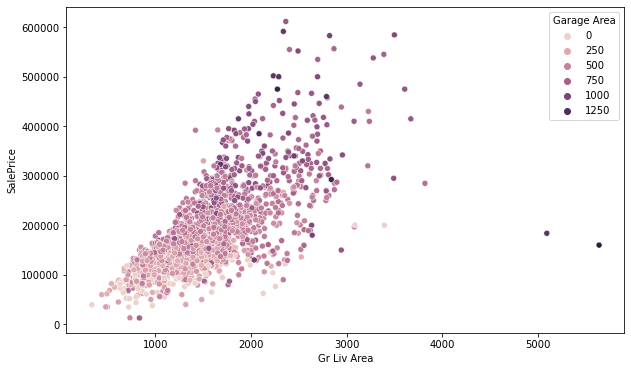

In [17]:
# plotting some scater plots to salesprice
plt.figure(figsize = (10,6))
sns.scatterplot(data=housing_EDA, x='Gr Liv Area', y='SalePrice', hue='Garage Area');

#2 outliers

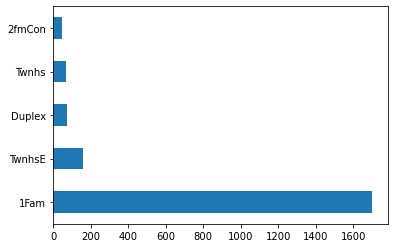

In [18]:
#count of bldg type in dataset
housing_EDA['Bldg Type'].value_counts().plot(kind='barh');

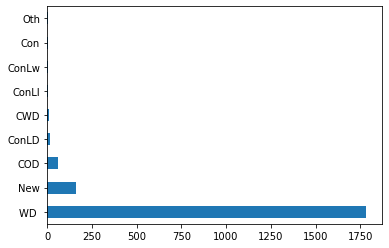

In [19]:
# based on my question, I was wondering if count of saletype is an indicator of participating in the housing program
# sample size is small though so will not use this for any insights
housing_EDA['Sale Type'].value_counts().plot(kind='barh');

In [20]:
# exploring data for homebuyers that qualify for low-interest, low-mortgage rate programs
homebuyer = housing_EDA[(housing_EDA['Sale Type'] == 'ConLI') | (housing_EDA['Sale Type'] == 'ConLD') | (housing_EDA['Sale Type'] == 'ConLw')]

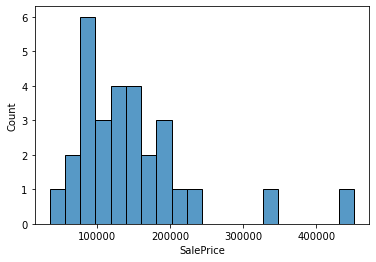

In [21]:
homebuyer = homebuyer.sort_values('SalePrice', ascending = False)
sns.histplot(data=homebuyer, x='SalePrice', bins=20);

# not sure if the filtering I did above represent homebuyers from the HOME program. If it does, it does indicate that the typical house price stays below 250K

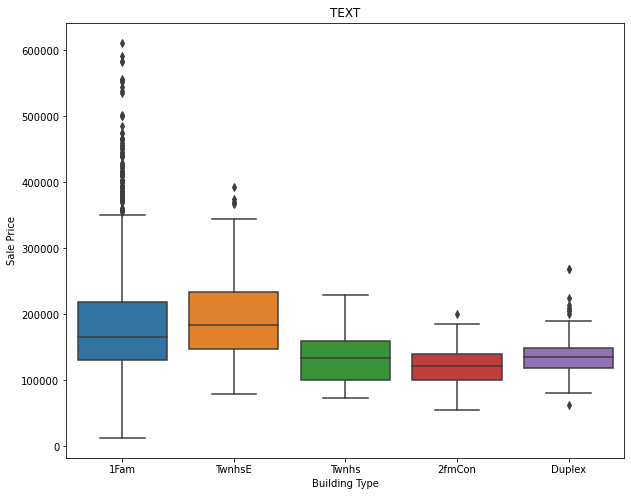

In [26]:
#box plot bldgtype/saleprice
bldgtype = housing_EDA[['SalePrice','Bldg Type']]

plt.subplots(figsize=(10, 8))
sns.boxplot(x='Bldg Type', y="SalePrice", data=bldgtype)
plt.xlabel('Building Type')
plt.ylabel('Sale Price')
plt.title('TEXT');

# based on this box plot you can see that the range for townhomes is smaller, which could help to limit choices to townhomes

---

### Checking for & cleaning nulls

In [17]:
#return list of columns with nulls
#housing.columns[housing.isnull().any()]
nulls = pd.DataFrame(housing.isnull().sum())
nulls.loc[nulls[0] != 0]

#26 rows with nulls

,0
Lot Frontage,330
Alley,1911
Mas Vnr Type,22
Mas Vnr Area,22
Bsmt Qual,55
Bsmt Cond,55
Bsmt Exposure,58
BsmtFin Type 1,55
BsmtFin SF 1,1
BsmtFin Type 2,56


### Dropping rows & columns where it's helpful

In [18]:
#dropping rows in columns where there aren't that many nulls - Bsmt Full Bath, Bsmt Half Bath, Garage Cars, Garage Area b/c it's a very small percentage of rows being dropped

housing.dropna(subset=['Bsmt Full Bath','Bsmt Half Bath','Garage Cars','Garage Area'], inplace=True)

### Engineer new columns
looking at nulls for some of these values, I decided to create new columns that might be more helpful
- does it have a garage?
- does it have a pool?
- does it have a basement?
- does it have a fence?
- does it have an alley?

In [19]:
housing['has_garage'] = np.where(housing['Garage Type'].isna(), 0, 1)
housing['has_pool'] = np.where(housing['Pool QC'].isna(), 0, 1)
housing['has_basement'] = np.where(housing['Bsmt Qual'].isna(), 0, 1)
housing['has_fence'] = np.where(housing['Fence'].isna(), 0, 1)
housing['has_alley'] = np.where(housing['Alley'].isna(), 0, 1)

In [20]:
#doublechecking that columns were mapped correctly
housing['has_alley'].value_counts()

0    1908
1     140
Name: has_alley, dtype: int64

### Drop columns that have a very high percentage of nulls (>than 50% nulls). The values in the newly engineered columns will be more helpful

In [21]:
#drop columns that have a very high percentage of nulls (>than 50% nulls). The values in the newly engineered columns will be more helpful

housing.drop(columns = ['Pool QC', 'Alley', 'Fireplace Qu', 'Fence'], inplace=True)

In [22]:
housing.shape

(2048, 82)

### Removed outliers from the dataset observed above in scatter plot (data dictionary also says to remove partial sales)

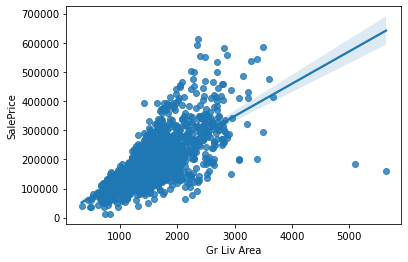

In [23]:
sns.regplot(x=housing['Gr Liv Area'], y=housing['SalePrice']);
# two outliers here

In [24]:
# dropping sale price outliers based on gr liv area feature
housing = housing[housing['Gr Liv Area'] <= 4000]

In [25]:
housing.shape

(2046, 82)

### Rename columns

In [26]:
# remove spaces in column names
housing.columns = [col.replace(' ', '') for col in housing.columns]

In [27]:
# remove spaces in column names
housing.columns = [col.replace('/', '_') for col in housing.columns]

In [28]:
# rename columns to lowercase
housing.columns = [col.lower() for col in housing.columns]     #list comprehension to rename cols
housing.head(2)

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,...,miscval,mosold,yrsold,saletype,saleprice,has_garage,has_pool,has_basement,has_fence,has_alley
0,109,533352170,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,...,0,3,2010,WD,130500,1,0,1,0,0
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,0,4,2009,WD,220000,1,0,1,0,0


### Export Pre-Pre-Processing Dataset

In [29]:
import os

# os.mkdir("cleaned_datasets")  #create a cleaned_data folder within my projects folder
# I commented out this code since the folders/files are already created and don't run into an error when I rerun cells

In [77]:
#export dataset to csv

housing.to_csv('cleaned_datasets/housing_preprocessed1_data.csv', index = False)